In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
# 시각화 결과물을 주피터에 내장 시키기 위해 
%matplotlib inline
# 한글처리 
import platform
from matplotlib import font_manager, rc
# 한글처리
plt.rcParams['axes.unicode_minus'] = False
if platform.system() == 'Darwin':    # 맥
    rc( 'font', family='AppleGothic' )
elif platform.system() == 'Windows': # 윈도우
    # 폰트 차후 확인
    fontPath = 'c:/Windows/Fonts/malgun.ttf'
    fontName = font_manager.FontProperties( fname=fontPath ).get_name()
    rc( 'font', family=fontName )
else:
    print('알수없는 시스템. 미적용')

In [3]:
import warnings
warnings.filterwarnings('ignore')
#분석용
import pandas as pd 
import numpy as np
#주식 데이터 로드용
from pandas_datareader import data

from fbprophet import Prophet
from datetime import datetime

In [6]:
sh_raw_df = pd.read_csv('./data/DAY_CARD_SPENDING.csv',sep='|')

In [10]:
sh_raw_df.head(10)

,STD_YM,GU_CD,DONG_CD,MCT_CAT_CD,DAY_CD,USE_CNT,USE_AMT
0,201601,65,101,1,1,914,37910721
1,201601,65,101,1,2,343,12191094
2,201601,65,101,1,3,400,16122078
3,201601,65,101,1,4,426,19893142
4,201601,65,101,1,5,489,19934581
5,201601,65,101,1,6,662,31673502
6,201601,65,101,1,7,989,47772055
7,201601,65,101,2,1,10,3349987
8,201601,65,101,2,2,10,1941975
9,201601,65,101,2,3,19,3500624


In [11]:
sh_raw_df.tail(10)

,STD_YM,GU_CD,DONG_CD,MCT_CAT_CD,DAY_CD,USE_CNT,USE_AMT
86153,201612,71,114,35,5,1474,28625669
86154,201612,71,114,35,6,1537,35017609
86155,201612,71,114,35,7,1887,28086410
86156,201612,71,114,36,1,114,1833296
86157,201612,71,114,36,2,301,14892564
86158,201612,71,114,36,3,253,18310310
86159,201612,71,114,36,4,282,14273384
86160,201612,71,114,36,5,358,17928165
86161,201612,71,114,36,6,555,38520962
86162,201612,71,114,36,7,436,62138785


In [8]:
len(sh_raw_df.index)

86163

In [16]:
#월간 기준으로 데이터 통합.(합산)
sh_piv = sh_raw_df.pivot_table(index='STD_YM',aggfunc=np.sum)

In [18]:
sh_piv.head()

,DAY_CD,GU_CD,MCT_CAT_CD,USE_AMT,USE_CNT
STD_YM,,,,,
201601,28809,489331,138924,2382735670973,67144975
201602,28778,487908,138919,2120307949014,61356872
201603,29093,492996,140040,2302527298754,70218606
201604,29067,492780,140100,2330465172133,72081717
201605,29054,494240,140417,2378041193406,75424273
201606,28977,491795,140064,2376154888745,75676560
201607,28958,491121,139769,2408235033944,79586889
201608,28868,490012,139466,2407739317921,81103926
201609,29013,492709,140019,2268362941444,73385070


In [19]:
sh_piv.columns

Index(['DAY_CD', 'GU_CD', 'MCT_CAT_CD', 'USE_AMT', 'USE_CNT'], dtype='object')

In [51]:
#결제 건수에 대한 예측(학습데이터가 1년주기 밖에 없음.)
df = pd.DataFrame({'ds':sh_piv.index, 'y':sh_piv['USE_CNT']})

In [52]:
df.reset_index(inplace=True)
del df['STD_YM']

In [53]:
df

,ds,y
0,201601,67144975
1,201602,61356872
2,201603,70218606
3,201604,72081717
4,201605,75424273
5,201606,75676560
6,201607,79586889
7,201608,81103926
8,201609,73385070
9,201610,76759121


In [31]:
# 현재 ds의 데이터가 201601 => 2016-01
# 방법1
ds_list=[]
for element in df['ds']:
    month = str(element)
    ds_list.append(month[:4]+'-'+month[4:])
ds_list

['2016-01',
 '2016-02',
 '2016-03',
 '2016-04',
 '2016-05',
 '2016-06',
 '2016-07',
 '2016-08',
 '2016-09',
 '2016-10',
 '2016-11',
 '2016-12']

In [33]:
df['ds']=ds_list

In [34]:
df

,ds,y
0,2016-01,67144975
1,2016-02,61356872
2,2016-03,70218606
3,2016-04,72081717
4,2016-05,75424273
5,2016-06,75676560
6,2016-07,79586889
7,2016-08,81103926
8,2016-09,73385070
9,2016-10,76759121


In [45]:
#방법2
df['ds'] = df['ds'].apply(lambda element : str(element)[:4]+'-'+str(element)[4:])
#df['ds']=df['ds'].apply(lambda x : '%s-%s' % (str(x)[:4],str(x)[-2:])) #강사님

In [55]:
#방법3
df# 알아서해봐
#pd.to_datetime(df['ds'],format='%y-%m') #이 방법도 평소엔 좋은 방법이지만, 컴퓨터는 아무 구분자 없이 분리 할 수 없다. 

ValueError: time data 201601 does not match format '%y-%m' (match)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 8.0.
D:\anaconda\lib\site-packages\fbprophet\forecaster.py:353: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  np.linspace(0, hist_size - 1, self.n_changepoints + 1)


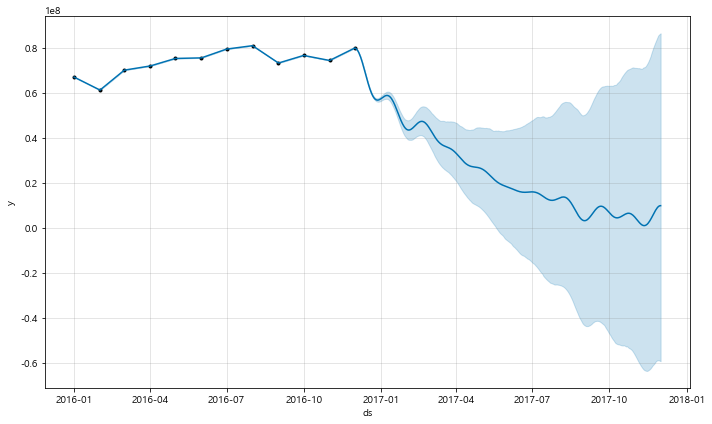

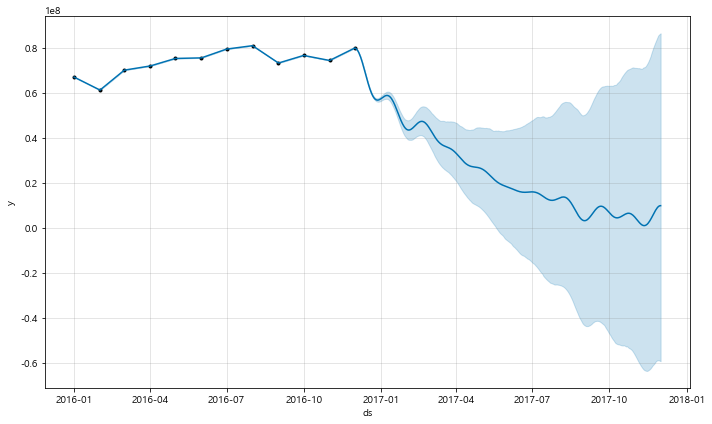

In [48]:
#1. 모델생성
m = Prophet(yearly_seasonality=True)
#2. 학습
m.fit(df)
#3. 예측에 필요한 변수 생성
fu = m.make_future_dataframe(periods = 365)
#4. 예측
forecast = m.predict(fu)
# 시각화
m.plot(forecast)


### =>데이터가 너무 없어서 정확성이 떨어진다

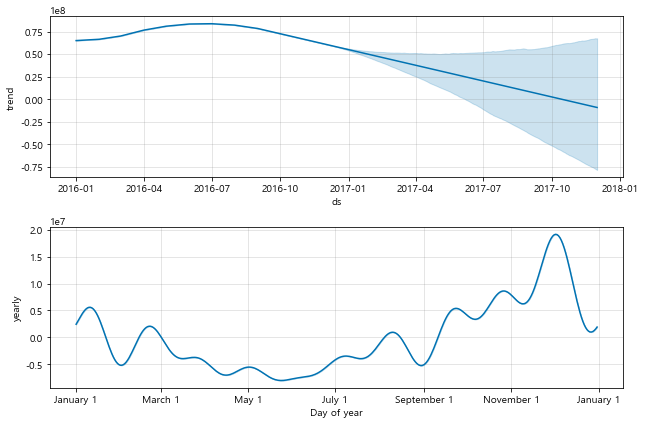

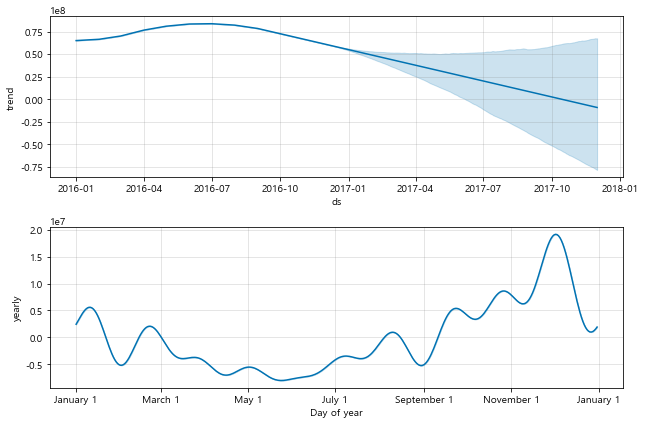

In [50]:
m.plot_components(forecast)

### =>시계열 처리는 연속된 시간 정보가 충분히 있어야한다.